<a href="https://colab.research.google.com/github/N0taName/NN-with-PSO-/blob/main/PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torchmetrics

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import copy
import matplotlib
from matplotlib import pyplot as plt
import torchmetrics
from torchmetrics import Accuracy
import numpy as np

In [117]:
def create_velocity(model):
  velocity = []
  for m in model:
    if isinstance(m, nn.Linear):
      velocity.append(torch.rand_like(m.weight))
  return velocity

In [118]:
def update_velocity(model,velocity,global_best,local_best,alpha=1,beta=1,theta=0.7,rand_seed=42):
  new_velocity = []
  j=0
  for i in range(len(model)):
    if isinstance(model[i], nn.Linear):
      new_velocity.append(theta*velocity[j]+alpha*np.random.rand()*(global_best[i].weight-model[i].weight)+np.random.rand()*beta*(global_best[i].weight-model[i].weight))
      j+=1
  return new_velocity

In [119]:
def update_position(model,velocity):
  j=0
  for i in range(len(model)):
    if isinstance(model[i], nn.Linear):
      model[i].weight = nn.Parameter(model[i].weight+velocity[j])
      j+=1
  return model

In [120]:
def create_particle(model):
  new_model = copy.deepcopy(model)
  for i in range(len(new_model)):
    if isinstance(new_model[i], nn.Linear):
      nn.init.uniform_(new_model[i].weight,a=-1,b=1)
  return new_model

In [126]:
def train(model,metric,data,labels,iterations=100,n_particles=50,alpha=1,beta=1,theta=0.7,minim=True,rand_seed=42):
  np.random.seed(rand_seed)
  particles = [create_particle(model) for _ in range(n_particles)]
  global_best = None
  global_best_y = None
  global_best_hist=[]
  local_bests = [None for _ in range(n_particles)]
  local_bests_y = [None for _ in range(n_particles)]
  velocities = [create_velocity(model) for _ in range(n_particles) ]
  for _ in tqdm.tqdm(range(iterations)):
    results = [metric(particles[i](data),labels).detach().numpy() for i in range(n_particles)]
    for i in range(n_particles):
      if global_best_y is None or (global_best_y > results[i] and minim) or (global_best_y < results[i] and not minim):
        global_best_y = results[i]
        global_best = copy.deepcopy(particles[i])
      if local_bests_y[i] is None or (local_bests_y[i] > results[i] and minim) or (local_bests_y[i] < results[i] and not minim):
        local_bests_y[i] = results[i]
        local_bests[i] = copy.deepcopy(particles[i])
    for i in range(n_particles):
      particles[i] = update_position(particles[i],velocities[i])
      velocities[i] = update_velocity(particles[i],velocities[i],global_best,local_bests[i],alpha=alpha,beta=beta,theta=theta)
    #print(results)
    global_best_hist.append(global_best_y.item())
  plt.plot(global_best_hist)
  plt.show()
  return global_best

Тестирование

In [127]:
import torchvision
from torchvision import transforms

transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.ConvertImageDtype(dtype=torch.float32)
    ])

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [128]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,10,dtype=torch.float32),
    nn.Sigmoid()
)

In [129]:
training_set.data = training_set.data.type(torch.float32)

100%|██████████| 500/500 [09:43<00:00,  1.17s/it]


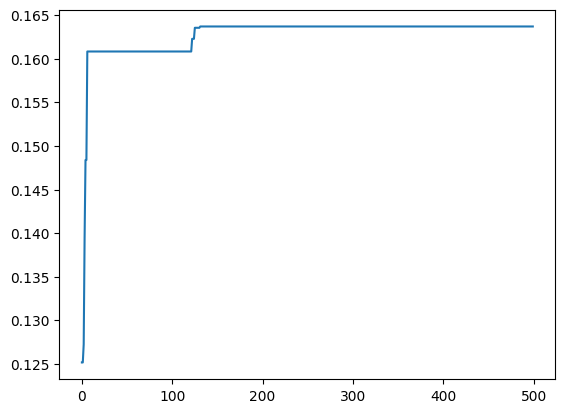

In [130]:
best_model = train(
    model=model,
    metric=Accuracy(task="multiclass", num_classes=len(classes)),
    data=training_set.data,
    labels=training_set.targets,
    iterations=500,n_particles=20,alpha=4,beta=4,minim=False)

In [65]:
validation_set.data = validation_set.data.type(torch.float32)

In [67]:
from sklearn import metrics

y_pred = best_model(validation_set.data)

In [72]:
1/len(classes)

0.1

ModuleNotFoundError: No module named 'torchmetrics'

In [68]:
y_pred

tensor([[0., 0., 1.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 1., 1., 1.]], grad_fn=<SigmoidBackward0>)

In [69]:
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]

In [70]:
metrics.accuracy_score(validation_set.targets.detach().numpy(),tmp)

0.171

In [71]:
nn.CrossEntropyLoss()(y_pred,validation_set.targets).item()

2.263460636138916

Тестирование на табличных данных